In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
from tqdm import tqdm
from typing import List, Optional

from catboost import cv, CatBoostClassifier, Pool

%matplotlib inline
sns.set(font_scale=1.25)

Задание 1:
    
1. Сделать базовый анализ данных: вывести размерность датасетов, посчитать базовые статистики, выполнить анализ пропусков, сделать выводы;
2. Сделать базовый анализ целевой переменной, сделать выводы;
3. Построить распределение признаков в зависимости от значения целевой переменной и распределение признаков для обучающей и тестовой выборки (если машина не позволяет построить распределение для всех признаков, то выполнить задание для признаков var_0, var_1, var_2, var_5, var_9, var_10, var_13, var_20, var_26, var_40, var_55, var_80, var_106, var_109, var_139, var_175, var_184, var_196), сделать выводы;
4. Построить распределение основных статистики признаков (среднее, стандартное отклонение) в разрезе целевой переменной и распределение основных статистик обучающей и тестовой выборки, сделать выводы;
5. Построить распределение коэффициентов корреляции между признаками. Есть ли зависимость между признаками (будем считать, что связь между признаками отсутствует, если коэффициент корреляции < 0.2)?
6. Выявить 10 признаков, которые обладают наибольшей нелинейной связью с целевой переменной.
7. Провести анализ идентичности распределения признаков на обучающей и тестовой выборках, сделать выводы.

Ссылка на наборы данных: https://drive.google.com/file/d/1j8zuKbI-PW5qKwhybP4S0EtugbPqmeyX/view?usp=sharing

p.s. это обязательная программа для выполнения домашки, вы можете расширить эту программу и сделать больше; я только за :)

# 1. Базовый анализ данных

Данные для обучения и теста:

In [2]:
train_df = pd.read_csv('train.csv')
train_df.head(n=5)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [3]:
test_df = pd.read_csv('test.csv')
test_df.head(n=5)

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


Размерности датафреймов:

In [4]:
print("train_df.shape = {} rows, {} cols".format(*train_df.shape))
print("test_df.shape = {} rows, {} cols".format(*test_df.shape))

train_df.shape = 200000 rows, 202 cols
test_df.shape = 200000 rows, 201 cols


Узнаем типы признаков:

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 201 entries, ID_code to var_199
dtypes: float64(200), object(1)
memory usage: 306.7+ MB


In [7]:
test_df.select_dtypes(include='object').columns.tolist()

['ID_code']

Судя по всему, пропуски в данных отсутствуют (проверим также далее).<br>Данные состоят из 200 числовых признаков (предположительно непрерывных) и одного категориального (`ID_code`). В данных для обучения есть есть целочисленный признак `target`.

Узнаем, содержатся ли в признаке `ID_code` идентификаторы каждой записи. Если да (**assert** пройдёт), то от признака можно будет избавиться:

In [8]:
assert train_df.shape[0] == train_df['ID_code'].nunique()
assert test_df.shape[0] == train_df['ID_code'].nunique()

200 общих целочисленных признаков и целевой признак:

In [9]:
feature_columns = [f'var_{i}' for i in range(200)]
target_column = 'target'

Проверим, что пропусков в данных для обучения и теста нет:

In [10]:
print(f"NaNs in train_df: {train_df[feature_columns + [target_column]].isnull().values.sum()}")
print(f"NaNs in test_df:  {test_df[feature_columns].isnull().values.sum()}")

NaNs in train_df: 0
NaNs in test_df:  0


Базовые статистики данных для обучения и теста:

In [11]:
train_df[feature_columns].describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,7.567236,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,1.235070,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,3.970500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,6.618800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,7.629600,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,8.584425,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,11.150600,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [12]:
test_df[feature_columns].describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.658737,-1.624244,10.707452,6.788214,11.076399,-5.050558,5.415164,16.529143,0.277135,7.569407,...,3.189766,7.458269,1.925944,3.322016,17.996967,-0.133657,2.290899,8.912428,15.869184,-3.246342
std,3.036716,4.040509,2.633888,2.052724,1.616456,7.869293,0.864686,3.424482,3.333375,1.231865,...,4.551239,3.025189,1.479966,3.995599,3.140652,1.429678,5.446346,0.920904,3.008717,10.398589
min,0.188700,-15.043400,2.355200,-0.022400,5.484400,-27.767000,2.216400,5.713700,-9.956000,4.243300,...,-14.093300,-2.407000,-3.340900,-11.413100,9.382800,-4.911900,-13.944200,6.169600,6.584000,-39.457800
25%,8.442975,-4.700125,8.735600,5.230500,9.891075,-11.201400,4.772600,13.933900,-2.303900,6.623800,...,-0.095000,5.166500,0.882975,0.587600,15.634775,-1.160700,-1.948600,8.260075,13.847275,-11.124000
50%,10.513800,-1.590500,10.560700,6.822350,11.099750,-4.834100,5.391600,16.422700,0.372000,7.632000,...,3.162400,7.379000,1.892600,3.428500,17.977600,-0.162000,2.403600,8.892800,15.943400,-2.725950
75%,12.739600,1.343400,12.495025,8.327600,12.253400,0.942575,6.005800,19.094550,2.930025,8.584825,...,6.336475,9.531100,2.956000,6.174200,20.391725,0.837900,6.519800,9.595900,18.045200,4.935400
max,22.323400,9.385100,18.714100,13.142000,16.037100,17.253700,8.302500,28.292800,9.665500,11.003600,...,20.359000,16.716500,8.005000,17.632600,27.947800,4.545400,15.920700,12.275800,26.538400,27.907400


Приверим, есть ли в данных признаки, которые можно считать категориальными. Считаем признак категориальным, если множество принимаемых им уникальных значений не превышает 15:

In [13]:
cat_features = []
for feature in tqdm(feature_columns):
    if train_df[feature].nunique() <= 15:
        cat_features.append(feature)
cat_features

100%|████████████████████████████████████████| 200/200 [00:03<00:00, 62.95it/s]


[]

Таких признаков найти не удалось. Считаем все 200 признаков количественными.

# 2. Базовый анализ целевого признака

Целе6вой признак `target` является бинарным:

In [14]:
train_df[target_column].value_counts()

0    179902
1     20098
Name: target, dtype: int64

Наблюдается дисбаланс классов (негативных примеров почти в девять раз больше, чем позитивных) - перед обучением модели потребуется принять меры по его исправлению.

# 3.1. Распределение признаков в зависимости от значения целевого признака

Выделим ряд признаков:

In [15]:
selected_features = [f'var_{i}' for i in (0, 1, 2, 5, 9, 10, 13, 20, 26, 40, 55, 80, 106, 109, 139, 175, 184, 196)]

Построим плотности распределения вероятностей их значений отдельно при значениях негативного класса целевого признака, отдельно - для позитивного:

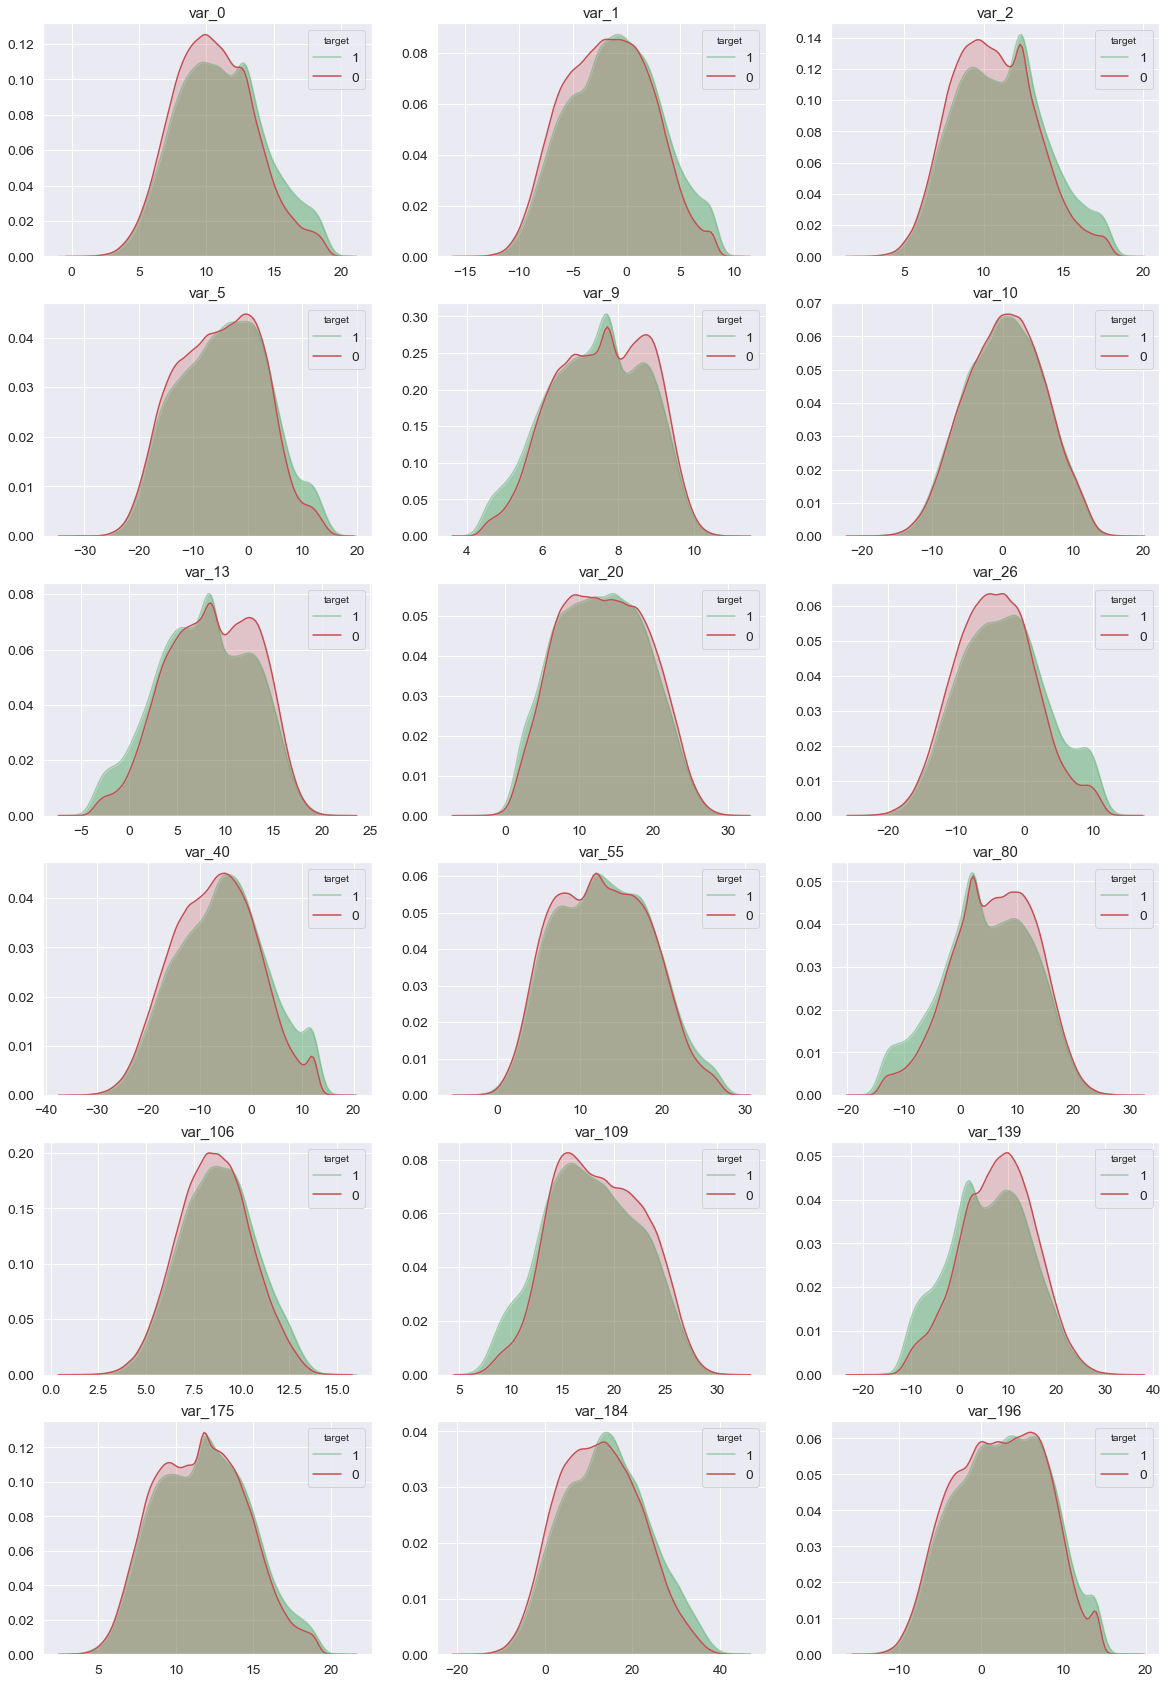

In [16]:
plt.figure(figsize=(20, 30))

for i, feature in enumerate(selected_features):
    plt.subplot(len(selected_features)//3, 3, i+1)
    plt.title(feature)
    sns.kdeplot(train_df.loc[train_df[target_column] == 1, feature], shade=True, alpha=0.5, label='1', color='g')
    sns.kdeplot(train_df.loc[train_df[target_column] == 0, feature], shade=True, label='0', color='r')
    plt.legend(loc='upper right', title=target_column)
plt.show()

Распределения колоколообразные, без ярко выраженных зон-выбросов, некоторые при таком количестве данных мультимодальны (2 или 3 моды).<br>Часть распределений при разных значениях целевого признака имеют небольшие смещения влево или вправо относительно друг друга:
 - распределение для негативного класса смещено левее распределения для позитивного класса у `var_0`, `var_1`, `var_2`, `var_5`, `var_26`, `var_40`, `var_106`, `var_175`, `var_184`, `var_196`;
 - -//- правее: y `var_9`, `var_13`, `var_80`, `var_109`, `var_139`.

# 3.2. Распределение признаков в данных для обучения и теста

Построим плотности распределения вероятностей значений выбранных признаков отдельно из данных для обучения, отдельно - из данных для теста:

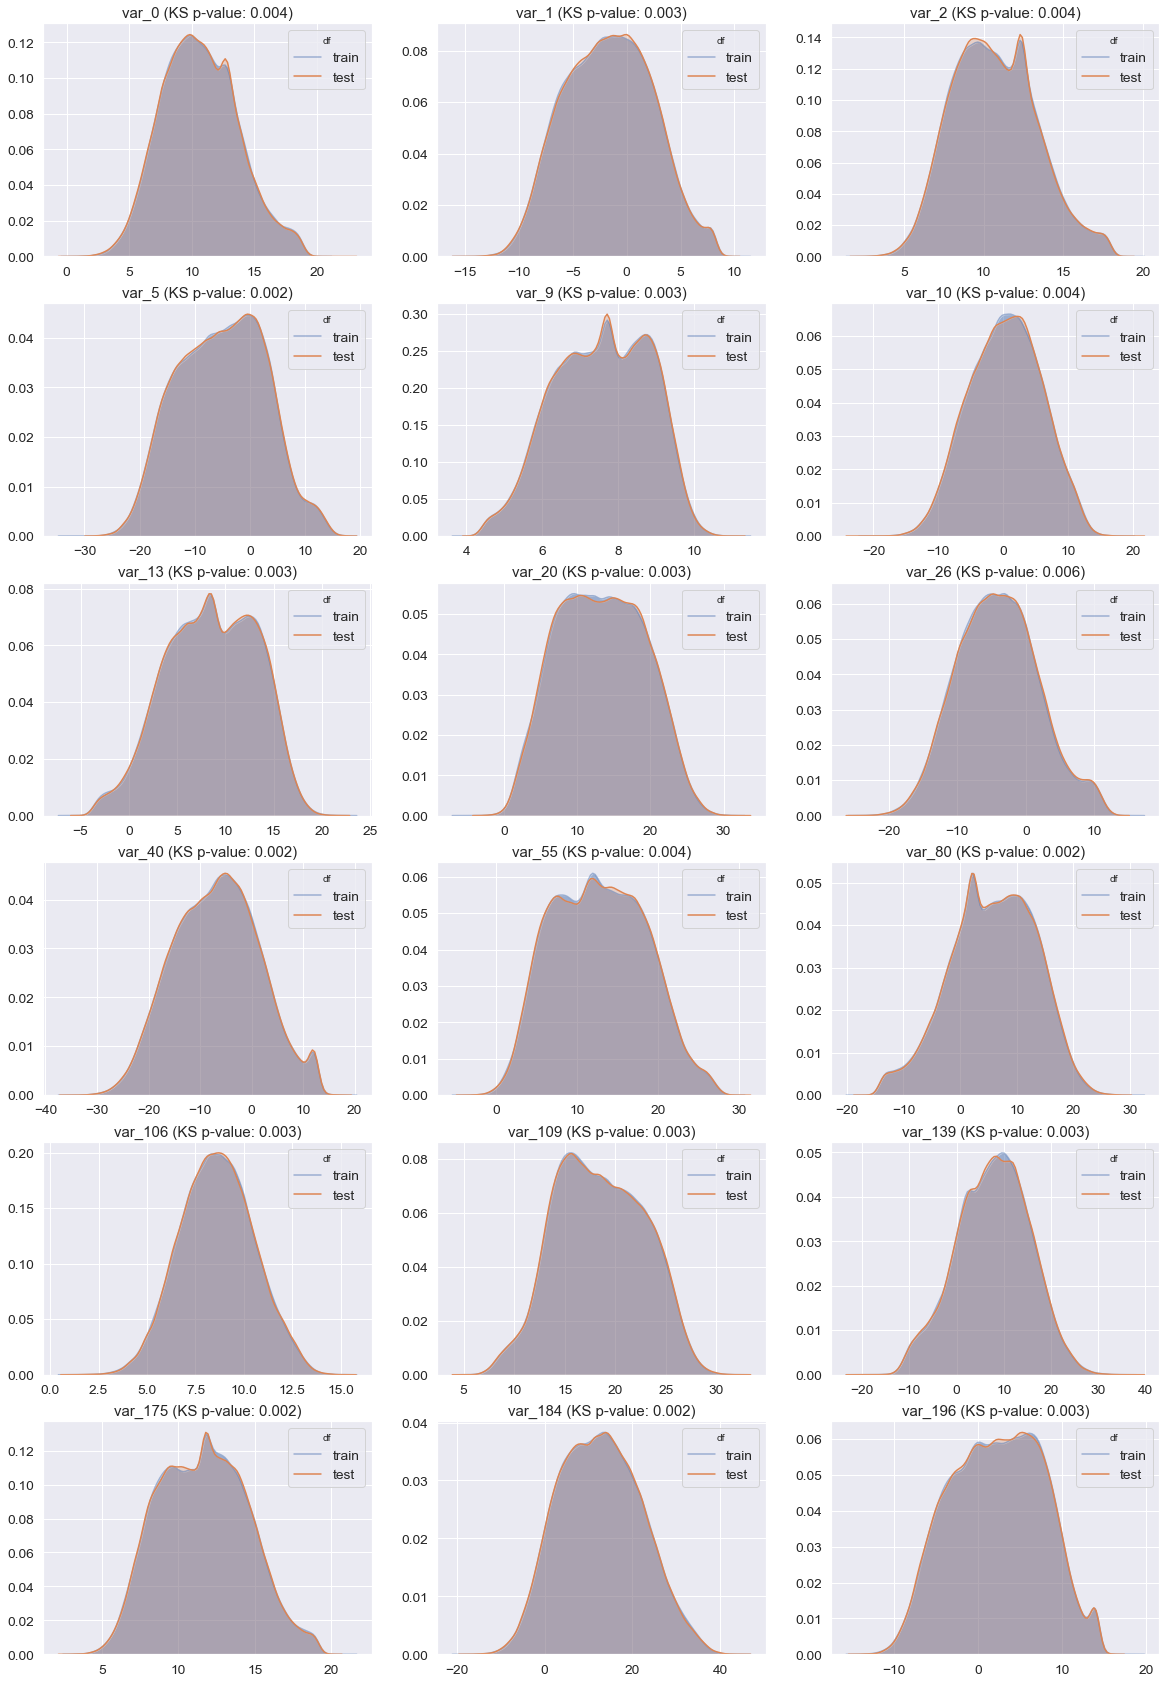

In [17]:
plt.figure(figsize=(20, 30))

for i, feature in enumerate(selected_features):
    statistic, pvalue = ks_2samp(
        train_df[feature],
        test_df[feature]
    )
    plt.subplot(len(selected_features)//3, 3, i+1)
    plt.title(f'{feature} (KS p-value: {statistic:.3f})')
    sns.kdeplot(train_df[feature], shade=True, alpha=0.5, label='train')
    sns.kdeplot(test_df[feature], shade=True, label='test')
    plt.legend(loc='upper right', title='df')
plt.show()

Визуально распределения значений признаков из данных для обучения и теста совпадают.

# 4.1. Распределение основных статистики признаков в разрезе целевого признака

Рассчитаем средние и стандартные отклонения выбранных признаков при разных значениях целевого признака:

In [18]:
gb = train_df[selected_features+[target_column]].groupby(by=[target_column]).agg(['mean', 'std'])
gb

var_0               var_1                var_2            \
             mean       std      mean       std       mean       std   
target                                                                 
0       10.626681  3.008564 -1.695770  4.024813  10.665876  2.612961   
1       11.156418  3.270293 -1.017613  4.220638  11.156633  2.841075   

           var_5               var_9            ...    var_109            \
            mean       std      mean       std  ...       mean       std   
target                                          ...                        
0      -5.146736  7.827522  7.584907  1.228839  ...  18.530675  4.322076   
1      -4.336522  8.140281  7.409064  1.278709  ...  17.807484  4.588738   

         var_139              var_175              var_184            \
            mean       std       mean       std       mean       std   
target                                                                 
0       7.950512  7.587266  11.619644  2.883026  12.606196  9.262205   
1       6.056607  8.331637  11.828309  2.966222  14.103659  9.702796   

         var_196            
            mean       std  
target                      
0       2.260297  5.441118  
1       2.688583  5.556892  

[2 rows x 36 columns]

Построим их гистограммы для их значений:

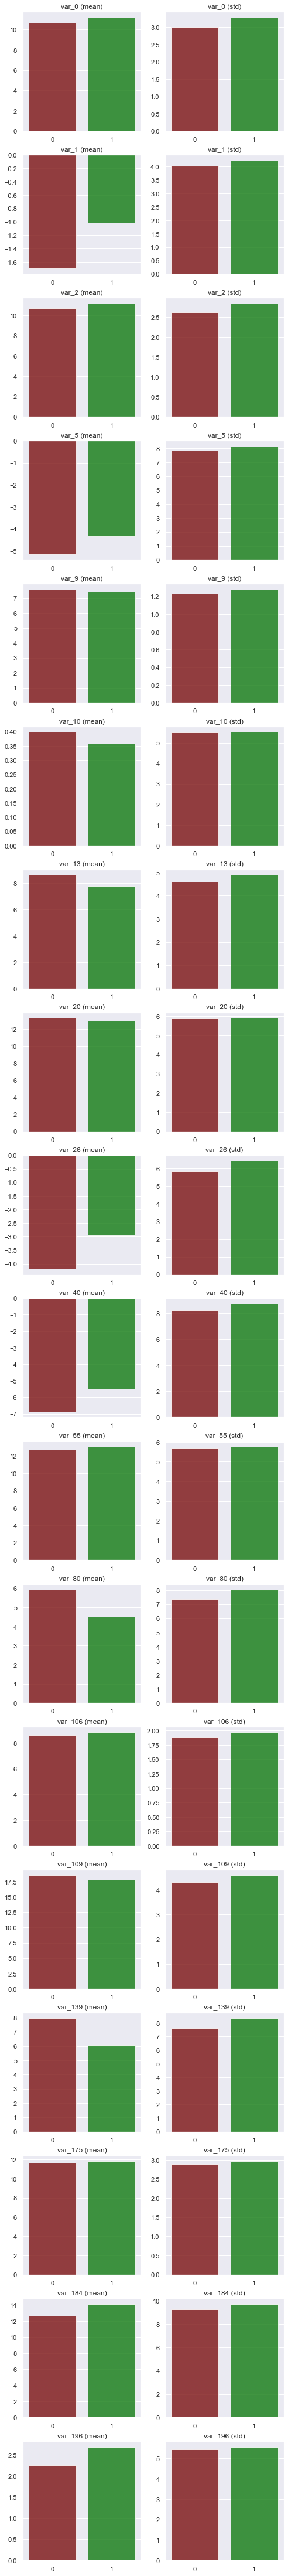

In [19]:
sns.set(font_scale=1.)
palette = np.array([[0.55, 0., 0.], [0., 0.55, 0.]])
fig = plt.figure(figsize=(8, 80))

for i, feature in enumerate(selected_features):
    for j, stat in enumerate(['mean', 'std']):
        plt.subplot(len(selected_features), 2, j+i*2+1)
        plt.title(f'{feature} ({stat})')
        sns.barplot([0, 1], gb[feature][stat].values, alpha=0.8, palette=palette)
    
plt.show()

По средним значениям признаков видно практически то же их разделение, которое отмечено в п. 3.1:
 - среднее значение признака при негативном классе явно меньше (т.к. распределение смещено левее), чем среднее значение признака при позитивном классе у `var_0`, `var_1`, `var_2`, `var_5`, `var_26`, `var_40`, `var_106`, `var_175`, `var_184`, `var_196`;
 - -//- больше: y `var_9`, **`var_10`** (хотя здесь распределения совпадают), `var_13`, `var_80`, `var_109`, `var_139`.

# 4.2. Распределение основных статистик в данных для обучения и теста

Рассчитаем основные статистики для выбранных признаков:

In [20]:
train_stats = train_df[selected_features].describe()
test_stats = test_df[selected_features].describe()

Покажем на гистограммах средние и стандартные отклонения каждого из признаков отдельно из данных для обучения, отдельно - из данных для теста:

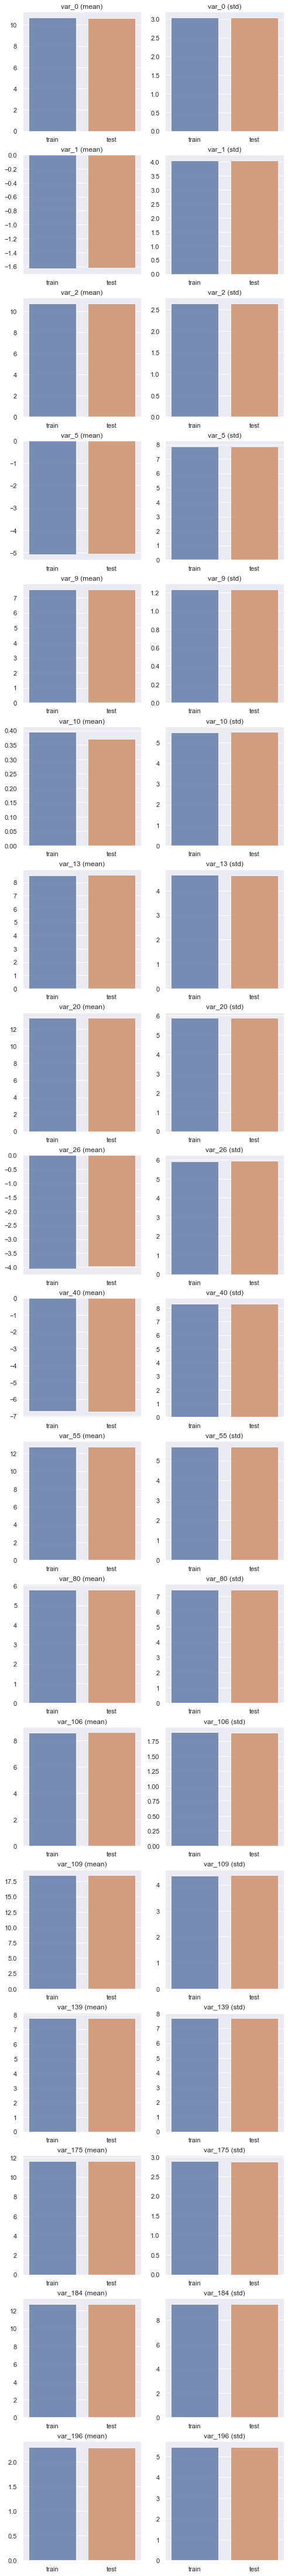

In [21]:
sns.set(font_scale=1.)
fig = plt.figure(figsize=(8, 80))

for i, feature in enumerate(selected_features):
    for j, stat in enumerate(['mean', 'std']):
        plt.subplot(len(selected_features), 2, j+i*2+1)
        plt.title(f'{feature} ({stat})')
        stat_values = [train_stats.loc[stat, feature], test_stats.loc[stat, feature]]
        sns.barplot(['train', 'test'], stat_values, alpha=0.8)
    
plt.show()

Они практически совпадают.

# 5. Корреляционный анализ

Рассчитаем корреляции выбранных признаков по методу Спирмена (ищет монотонные связи):

In [22]:
corr_matrix = train_df[selected_features].corr(method='spearman')

Построим карту полученной корреляционной матрицы и выберем те пары признаков, корреляция которых по модулю не меньше 0.2:

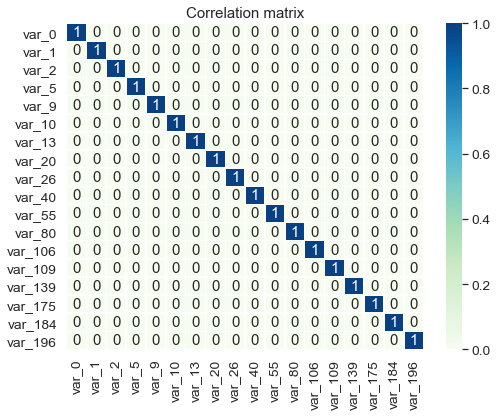

In [23]:
sns.set(font_scale=1.25)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix[corr_matrix.abs() >= 0.2].fillna(0.), annot=True, linewidths=.5, cmap='GnBu')
plt.title('Correlation matrix')
plt.show()

Таких пар высококоррелированных признаков нет.

# 6. Топ-10 признаков, нелинейно сильно связанных с целевым признаком

Обучим модель бустинга из библиотеки **catboost** на всех 200 признаках:

In [24]:
catb = CatBoostClassifier(eval_metric='F1', silent=True, random_state=42)
%time catb.fit(train_df[feature_columns], train_df[target_column]);

Wall time: 5min 50s


Топ-10 признаков по их важности согласно обученному классификатору:

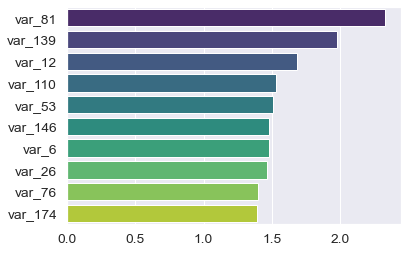

In [25]:
feature_importances = pd.Series(catb.feature_importances_, index=feature_columns).sort_values(ascending=False)
feature_importances = feature_importances.head(n=10)

sns.barplot(x=feature_importances.values, y=feature_importances.index, palette="viridis")
plt.show()

# 7. Анализ идентичности распределения признаков в данных для обучения и теста

## Population Stability Index

In [26]:
class PSI(BaseEstimator, TransformerMixin):
    """
    Вычисление PSI и отбор признаков на их основе.

    Parameters
    ----------
    threshold: float
        Порог для отбора переменных по PSI.
        Если PSI для переменной выше порога - переменная макрируется
        0 (не использовать для дальнейшего анализа), если ниже
        порога - маркируется 1 (использовать для дальнейшего анализа).

    categorical_features: List[str], optional, default = None
        Список категориальных признаков для анализа.
        Опциональный параметр, по умолчанию, не используется, т.е.
        категориальные признаки отсутствуют.

    n_bins: int, optional, default = 20
        Количество бинов, на которые разбивается выборка.

    min_value: float, optional, default = 0.005
        Значение которое используется, если рассчитанный psi = 0.

    bin_type: string, optional, default = "quanitles"
        Способ разбиения на бины: "quantiles" or "bins".
        При выборе "quantiles" - выборка будет разбита на n_bins
        квантилей, при выборке "bins" - выборка будет разбита на
        n_bins бакетов с равным шагом между бакетами.
        Иные значения приводят к возникновению ValueError.

    Attributes
    ----------
    scores_: Dict[str, float]
        Словарь со значениями PSI,
        ключ словаря - название признака, значение - PSI-score.

    """
    def __init__(self,
                 threshold: float,
                 categorical_features: Optional[List[str]] = None,
                 bin_type: str = "quantiles",
                 min_value: float = 0.005,
                 n_bins: int = 20):

        self.threshold = threshold
        self.categorical_features = categorical_features
        self.min_value = min_value
        self.n_bins = n_bins
        if bin_type in ["quantiles", "bins"]:
            self.bin_type = bin_type
        else:
            raise ValueError(
                "Incorrect bin_type value. Expected 'quantiles' or 'bins', "
                f"but {bin_type} is transferred."
            )
        self.scores = {}

    def calculate_bins(self, data: pd.Series) -> np.array:
        """
        Вычисление границ бинов для разбиения выборки.

        Parameters
        ----------
        data: pandas.Series, shape = [n_samples, ]
            наблюдения из train-выборки.

        Returns
        -------
        bins: numpy.array, shape = [self.n_bins + 1]
            Список с границами бинов.

        """
        if self.bin_type == "quantiles":
            bins = np.linspace(0, 100, self.n_bins + 1)
            bins = [np.nanpercentile(data, x) for x in bins]

        else:
            bins = np.linspace(data.min(), data.max(), self.n_bins + 1)

        return np.unique(bins)

    def calculate_psi_in_bin(self, expected_score, actual_score) -> float:
        """
        Вычисление значения psi для одного бакета.

        Осуществляется проверка на равенство нулю expected_score и
        actual_score: если один из аргументов равен нулю, то его
        значение заменяется на self.min_value.

        Parameters
        ----------
        expected_score: float
            Ожидаемое значение.

        actual_score: float
            Наблюдаемое значение.

        Returns
        -------
        value: float
            Значение psi в бине.

        """
        if expected_score == 0:
            expected_score = self.min_value
        if actual_score == 0:
            actual_score = self.min_value

        value = (expected_score - actual_score)
        value = value * np.log(expected_score / actual_score)

        return value

    def calculate_psi(self, expected: pd.Series, actual: pd.Series, bins) -> float:
        """
        Расчет PSI для одной переменной.

        Parameters
        ----------
        expected: pandas.Series, shape = [n_samples_e, ]
            Наблюдения из train-выборки.

        actual: pandas.Series, shape = [n_samples_o, ]
            Наблюдения из test-выборки.

        bins: pandas.Series, shape = [self.n_bins, ]
            Бины для расчета PSI.

        Returns
        -------
        psi_score: float
            PSI-значение для данной пары выборок.

        """
        expected_score = np.histogram(expected.fillna(-9999), bins)[0]
        expected_score = expected_score / expected.shape[0]

        actual_score = np.histogram(actual.fillna(-9999), bins)[0]
        actual_score = actual_score / actual.shape[0]

        psi_score = np.sum(
            [self.calculate_psi_in_bin(exp_score, act_score) \
             for exp_score, act_score in zip(expected_score, actual_score)]
        )

        return psi_score

    def calculate_numeric_psi(self, expected: pd.Series, actual: pd.Series) -> float:
        """
        Вычисление PSI для числовой переменной.

        Parameters
        ----------
        expected: pandas.Series, shape = [n_samples_e, ]
            Наблюдения из train-выборки.

        actual: pandas.Series, shape = [n_samples_o, ]
            Наблюдения из test-выборки.

        Returns
        -------
        psi_score: float
            PSI-значение для данной пары выборок.

        """
        bins = self.calculate_bins(expected)
        psi_score = self.calculate_psi(expected, actual, bins)
        return psi_score

    def calculate_categorical_psi(self, expected: pd.Series, actual: pd.Series) -> float:
        """
        Вычисление PSI для категориальной переменной.
        PSI рассчитывается для каждого уникального значения категории.

        Parameters
        ----------
        expected: pandas.Series, shape = [n_samples_e, ]
            Наблюдения из train-выборки.

        actual: pandas.Series, shape = [n_samples_o, ]
            Наблюдения из test-выборки.

        Returns
        -------
        psi_score: float
            PSI-значение для данной пары выборок.

        """
        bins = np.unique(expected).tolist()
        psi_score = self.calculate_psi(expected, actual, bins)
        return psi_score

    def fit(self, X, y=None):
        """
        Вычисление PSI-значения для всех признаков.

        Parameters
        ----------
        X: pandas.DataFrame, shape = [n_samples, n_features]
            Матрица признаков для обучения.

        y: pandas.DataFrame, shape = [n_samples, n_features]
            Матрица признаков для тестирования.

        Returns
        -------
        self
        """
        missed_columns = list(set(X.columns) - set(y.columns))

        if missed_columns:
            raise MissedColumnError(
                f"Missed {list(missed_columns)} columns in data.")

        if self.categorical_features:
            numeric_features = list(
                set(X.columns) - set(self.categorical_features)
            )
            for feature in self.categorical_features:
                self.scores[feature] = self.calculate_categorical_psi(
                    X[feature], y[feature]
                )
        else:
            numeric_features = X.columns

        for feature in tqdm(numeric_features):
            self.scores[feature] = self.calculate_numeric_psi(
                X[feature], y[feature]
            )
        return self

    def transform(self, X, y=None) -> pd.DataFrame:
        """
        Отбор переменных по self.threshold.
        Если PSI-score для переменной выше порога, то переменная
        помечается 0 (не использовать для дальнейшего анализа), если ниже
        порога - маркируется 1 (использовать для дальнейшего анализа).

        Parameters
        ----------
        data: pandas.DataFrame, shape = [n_samples, n_features]
            Матрица признаков для обучения.

        target: pandas.DataFrame, shape = [n_samples, n_features]
            Матрица признаков для тестирования.

        Returns
        -------
        scores: pandas.DataFrame, shape = [n_features, 3]
            Датафрейм с PSI-анализом переменных.

        """
        check_is_fitted(self, "scores")
        scores = pd.Series(self.scores)
        scores = pd.DataFrame({"Variable": scores.index, "PSI": scores.values})
        scores["Selected"] = np.where(scores.PSI < self.threshold, 1, 0)
        scores = scores.sort_values(by="PSI")

        mask = scores["Selected"] == 1
        self.used_features = scores.loc[mask, "Variable"].tolist()

        return scores.reset_index(drop=True)

Обучим объект на данных для обучения и теста:

In [27]:
psi = PSI(threshold=0.01)

In [28]:
psi_scores = psi.fit_transform(
    X=train_df[feature_columns],
    y=test_df[feature_columns]
)
psi_scores

100%|████████████████████████████████████████| 200/200 [00:27<00:00,  7.31it/s]


,Variable,PSI,Selected
0,var_154,0.000085,1
1,var_156,0.000132,1
2,var_5,0.000138,1
3,var_148,0.000150,1
4,var_35,0.000151,1
5,var_197,0.000168,1
6,var_36,0.000169,1
7,var_179,0.000179,1
8,var_71,0.000179,1
9,var_61,0.000183,1


Отобранными по порогу 0.01 оказались все 200 признаков - т.е. значимых отличий в их распределениях из данных для обучения и теста не выявлено:

In [29]:
len(psi.used_features)

200

## Adversarial Validation

In [30]:
X_adv = pd.concat([
    train_df[feature_columns],
    test_df[feature_columns]
])

y_adv = np.hstack((
    np.ones(train_df.shape[0]),
    np.zeros(test_df.shape[0])
))

X_adv = X_adv.reset_index(drop=True)

Обучим объект для кросс-валидации из библиотеки **catboost** с целевой метрикой ROC AUC -  по аналогии с примером, показанным на вебинаре: 

In [31]:
%%time
cv_dataset = Pool(
    data=X_adv,
    label=y_adv
)

params = {"n_estimators": 50,
          "depth": 4,
          "loss_function": "Logloss",
          'eval_metric': 'AUC', 
          "verbose": False}

adv_scores = cv(
    cv_dataset,
    params,
    fold_count=3, 
    shuffle=True,
    plot=False
)

Wall time: 2min 48s


Среднее значение метрики ROC AUC на тестовых подвыборках равно 0.5 - при достаточно малом стандартном отклонении:

In [32]:
adv_scores[[column for column in adv_scores.columns if 'AUC' in column]].mean()

test-AUC-mean    0.507068
test-AUC-std     0.002513
dtype: float64

Классификатор не нашел никаких отличий между данными для обучения и данными для теста - поэтому его работа сравнима с работой случайного классификатора.<br>Таким образом, распределения признаков в данных для обучения и теста согласно Adversarial Validation идентичны.